###**Redes Siamesas**

Las redes siamesas son un tipo de arquitectura de redes neuronales diseñadas para aprender similitudes entre pares de entradas, como imágenes, secuencias o textos. La característica clave de estas redes es que constan de dos (o más) subredes idénticas que comparten los mismos pesos y parámetros. Cada subred procesa una entrada diferente, y luego las salidas (o embeddings) se comparan utilizando una métrica de similitud o distancia.


Ahora entrenaremos una red siamesa que toma un par de imágenes y entrena los **embeddings** o **representaciones**, de forma que la distancia entre ellos se minimice si pertenecen a la misma clase, y sea mayor que un valor de margen si representan clases diferentes. Minimizarémos la función de pérdida *contrastive loss*, [https://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf]

También, para la implementación de las mismas y siguiendo el esquema de trabajo de las prácticas de la asignatura, usaremos FastAI para su implementación. Para ello, tendremos como referencia siguiente tutorial: [https://docs.fast.ai/tutorial.siamese.html]

In [5]:
from fastai.vision.all import *
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files
import torch
import numpy as np
import PIL
import random
from fastai.data.core import DataLoaders

path = untar_data(URLs.MNIST)
files = get_image_files(path)

Lo primero que haremos será descargar y procesar el primero de los datasets a usar, **`MNIST`**.

In [6]:
img = PIL.Image.open(files[0])
img

Para procesar las imágenes, las pasamos a **tensores** y al tamaño correspondiente.

In [7]:
def open_image(fname, size=32):
    img = PIL.Image.open(fname).convert('L')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.unsqueeze(0).float()/255.0

open_image(files[0]).shape

torch.Size([1, 32, 32])

In [8]:
def label_func(fname):
  '''
  Devuelve la clase o etiqueta dada una imagen
  '''
  return int(fname.parent.name)

In [9]:
labels = list(set(files.map(label_func)))
len(labels)

10

Como ya sabíamos, contamos con 10 clases distintas, $[0,9]$. Necesitaremos entonces un mapeo que nos lleve de una clase a la lista de archivos de dicha clase, para escoger más tarde un elemento aleatorio. Usamos el siguiente diccionario.

In [10]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

Tendremos que crear un `Dataset` de  propio, que hereda de *PyTorch*. Para el conjunto de entrenamiento, recorreremos todos los nombres de archivo para seleccionar la primera imagen y luego elegiremos aleatoriamente:

* Un nombre de archivo de la misma clase para la segunda imagen (con una probabilidad del 50%).
* Un nombre de archivo de una clase diferente para la segunda imagen (con una probabilidad del 50%)

Realizaremos este sorteo aleatorio cada vez que se acceda a un elemento, para generar la mayor cantidad posible de muestras. **Sin embargo, para el conjunto de validación, fijaremos este sorteo aleatorio de una vez por todas (de lo contrario, validaríamos con un conjunto de datos diferente en cada época)**.

In [11]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]

    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())

    def __len__(self): return len(self.files)

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(lbl2files[cls]),same

Una funcionalidad muy interesante sobre fastAI es que, cuando tenemos un dataset personalizado como ahora, lo podemos convertir en un `TransForm`. De esta manera, podremos aplicarlo al dataset entero.

In [15]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]

    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (TensorImage(img1), TensorImage(img2), torch.Tensor([same]).squeeze())

    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls])
        return random.choice(lbl2files[cls]),same

Podemos probar todo lo anterior haciendo una partición entre train y validación, por ejemplo, del $80\%$-$20\%$. Creamos así el siguiente dataset:

In [16]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

train_tl= TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [17]:
dls = DataLoaders.from_dsets(train_tl, valid_tl,
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda() #  Lo mandamos a GPU

Lo que hacemos a continuación es cambiar el método `show`, para que fastAI sea capaz de procesar nuestro nuevo dataset y poder llamar al método y de esta forma visualizar los elementos del dataset creado.

In [18]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

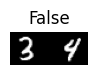

In [19]:
img = PILImage.create(files[0])
img1 = PILImage.create(files[2000])
s = SiameseImage(img, img1, False)
s.show();

Modificamos ahora nuestro transform anterior, para que se puedan leer directamente archivos. Así, la lectura de los conjuntos de train y validación será mucho más cómoda:

In [20]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, same)

    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls))
        return random.choice(self.splbl2files[split][cls]),same

Además, podemos hacer el proceso de **split** mucho más sencillo. Llamamos a `RandomSplitter()` y creamos el mismo dataset que teníamos antes. Al llamar a `TfmdLists`, creamos un conjunto de validación y de entrenamiento.

In [21]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)

Estamos en condiciones de crear finalmente nuestro **dataset**:

In [25]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*mnist_stats)])

Modificamos la función `show_batch()` de fastAI para mostrar elementos aleatorios de nuestro dataset:

In [26]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

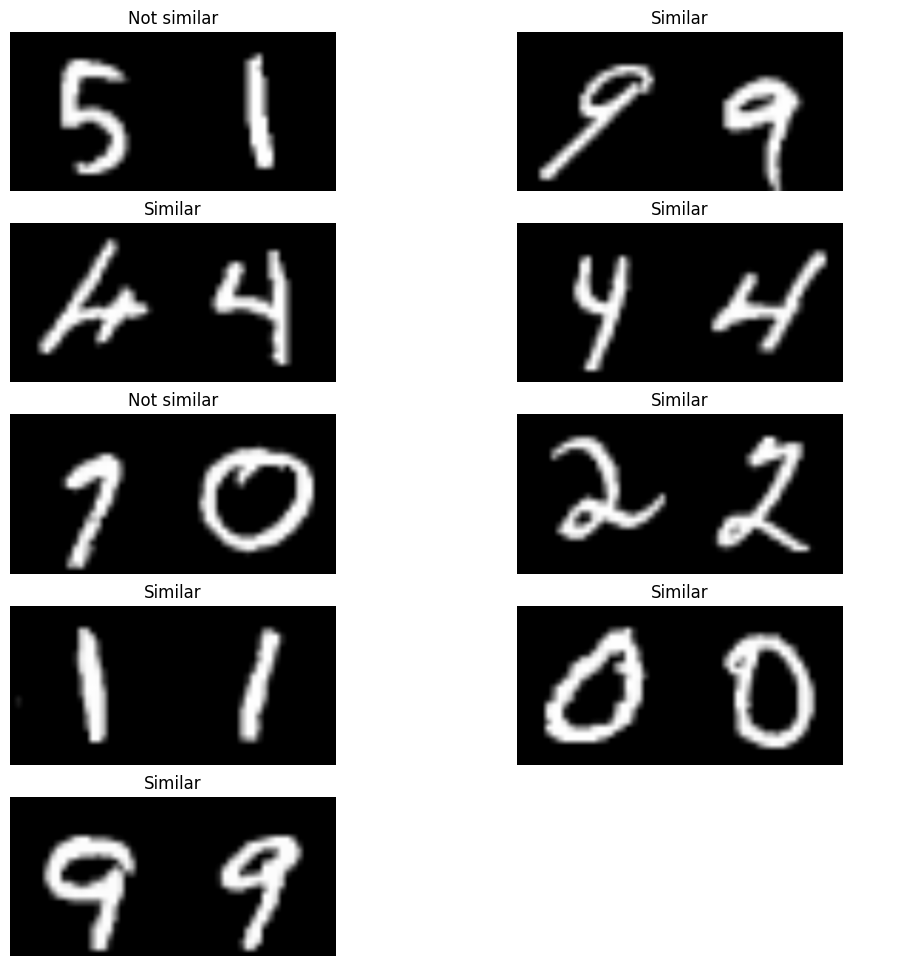

In [27]:
dls.show_batch()

Pasamos a la parte del **entrenamiento**. Para ello, debemos tener claro como funcionan las redes siamesas:

$$$$

En lugar de simplemente clasificar una entrada, estas redes comparan dos entradas y determinan si son similares o diferentes. Se entrenan usando pares de datos etiquetados como "similares" o "diferentes". De esto, es de lo que nos hemos encargado hasta ahora, nuestros datos ya son pares de imágenes.

**Componentes Clave:**
1. Encoder Compartido: Una red base (como una CNN) que transforma cada entrada en un espacio de características (embedding). Es importante que los pesos sean compartidos para garantizar que ambas entradas se procesen de manera idéntica.

2. Cálculo de Similitud: Después de obtener los embeddings, se calcula la similitud entre ellos, ya sea directamente con una métrica (como la distancia euclidiana) o pasando los embeddings por una red adicional para clasificar.
3. Pérdida Especializada: Se usan funciones de pérdida como la Contrastive Loss o la Triplet Loss, que están diseñadas para medir similitudes en el espacio latente. **Un primer acercamiento es usar `CrossEntropyFlat`, que es lo que haremos ahora, y ver que la red funciona. Más adelante compararemos con otro tipo de funciones de pérdida.**



In [28]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head

    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

* `encoder`:e s un modelo que toma una entrada (como una imagen) y la transforma en un vector de características (embedding). Este `encoder` se aplica a ambas entradas ($x_1$, $x_2$), y los pesos son compartidos para que las transformaciones sean consistentes.

* `head`: Una red adicional que toma como entrada la combinación de los **embeddings** y produce la salida final.

* `forward`: Obtiene los embeddings de las dos entradas (x1 y x2) pasando ambas por el `encoder`. Luego, Combina los embeddings de ambas entradas concatenándolos a lo largo del eje de características. La concatenación permitirá al modelo aprender relaciones complejas entre los dos **embeddings**.

In [42]:
model_meta[resnet18]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
 'weights': 'DEFAULT'}

Usaremos como encoder el backbone de **resnet18**, por eso usamos` cut = -2`.

In [43]:
encoder = create_body(resnet18(), cut=-2)

In [44]:
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [45]:
head = create_head(512*2, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [46]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

Ya tenemos nuestro modelo, es momento de entrenar. Para ello, creamos `siamese_splitter()`, que especificará al Learner, qué congelar y que no cuando queramos congelar pesos de la red. Diferenciará entre encoder y head.

Entrenamos como hemos hecho en las prácticas.

In [50]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [48]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*mnist_stats)])

In [49]:
valids = [v[0] for k,v in tfm.valid.items()]

In [51]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

In [52]:
learn.freeze()

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0008317637839354575)

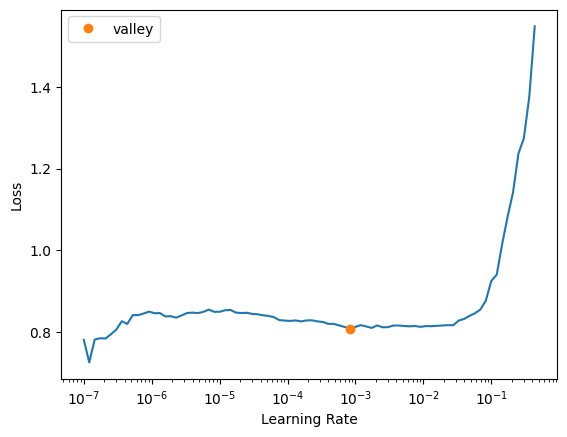

In [53]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(1, 8e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.536308,0.499749,0.748071,05:39


In [56]:
learn.unfreeze()

In [57]:
learn.fit_one_cycle(3, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.511540,0.482131,0.759214,06:47
1,0.489999,0.465077,0.769214,06:39
2,0.515084,0.460619,0.774857,06:41


In [64]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs):
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

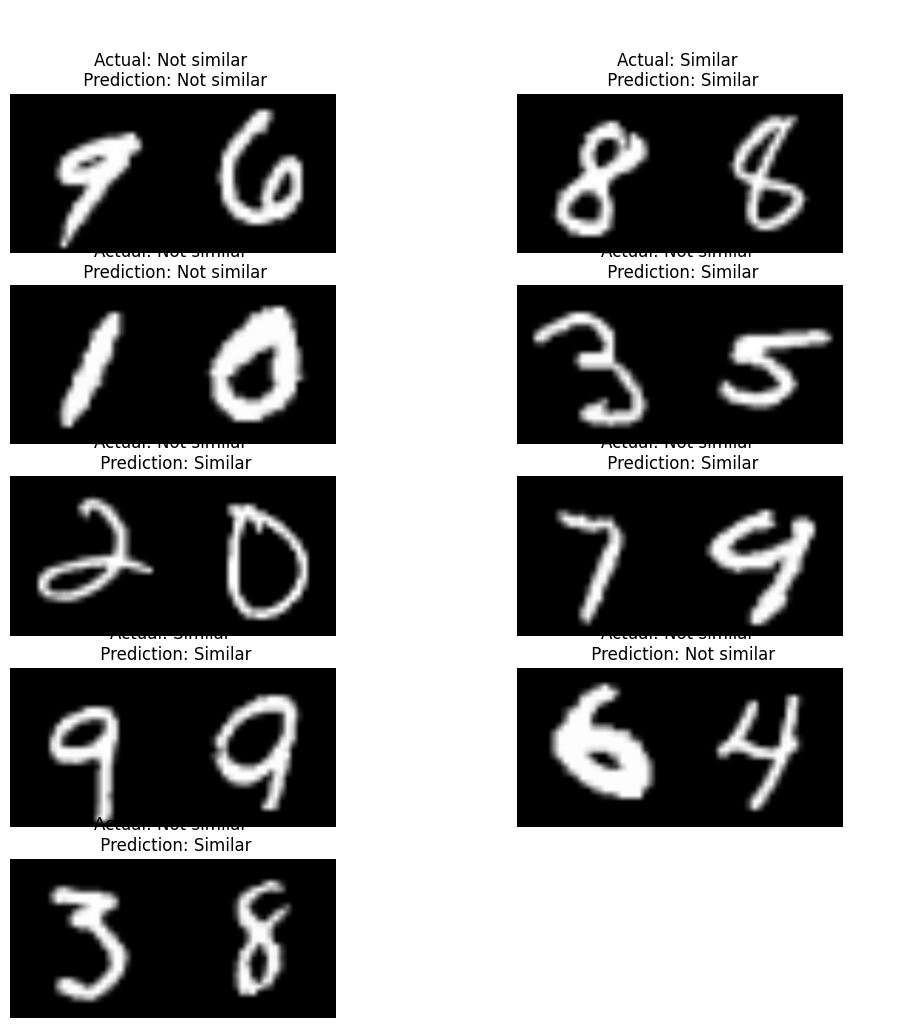

In [65]:
learn.show_results()

**TODO: Implementar y cambiar la funcion de perdida a contrastive loss, comparar con CrossEntropyLoss**

Posible explicación:

Vamos ahora con la **función de pérdida** a utilizar. Se trata de la clase `ContrastiveLoss`ya implementada en *Pytorch*.


La clase toma un argumento `m`, que representa un margen que separa los pares positivos y negativos. Las parejas distintas contribuyen a la función de pérdida solo si la distancia entre ellas está dentro del radio definido por `m`.

<center><img src = https://github.com/adambielski/siamese-triplet/blob/master/images/contrastive_loss.png?raw=true></center>

El resultado de la función forward es un valor escalar de pérdida que mide qué tan bien está desempeñándose el modelo en la tarea. La pérdida se calcula en función de qué tan cercana está la puntuación de similitud entre las entradas a la puntuación de similitud esperada (ground truth). Si la puntuación de similitud está cerca de la puntuación esperada, la pérdida será baja. Por el contrario, si la puntuación de similitud está lejos de la puntuación esperada, la pérdida será alta. La función de pérdida fomenta que el modelo aprenda representaciones de las entradas que capturen su similitud.



In [75]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [79]:
model = SiameseModel(encoder, head) # Redefinimos
loss_fn = ContrastiveLoss(1.0)
learn = Learner(dls, model, loss_func=loss_fn, splitter=siamese_splitter, metrics=accuracy)

In [80]:
learn.freeze()

In [81]:
learn.lr_find()

TypeError: ContrastiveLoss.forward() missing 1 required positional argument: 'target'